# DA11 Epoching
06/26/2023

In [7]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

In [8]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [9]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [10]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA11'
subj_format = ['nlx']
subj_site = ['UCD']


### Import Preprocessed Data

In [11]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [12]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 91 x 2609728 (5219.5 s), ~1.77 GB, data loaded>

In [13]:
photodiode_data

<Raw | photodiode.fif, 1 x 2609728 (5219.5 s), ~19.9 MB, data loaded>

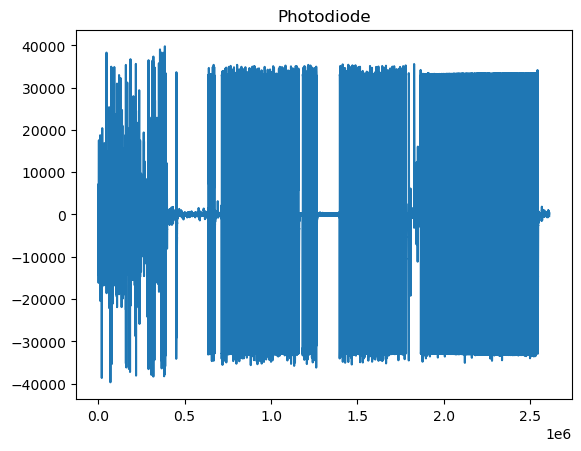

In [14]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [15]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination
0,LAM1,rHipp_L,-23.583114,13.677539,-14.846665,-21.787677,-3.071038,-27.563982,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left amygdala inferior,NaN
1,LAM2,lAmyg_L,-28.379682,12.878366,-14.846665,-26.646692,-4.016142,-27.115331,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Amyg,Left amygdala inferior,NaN
2,LAM3,lAmyg_L,-33.176250,12.079194,-14.846665,-31.485298,-4.962499,-26.790415,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Amyg,Left amygdala inferior,NaN
3,LAM4,A20rv_L,-37.972818,11.280022,-15.246466,-36.333955,-5.878473,-26.979067,White,Left Cerebral White Matter,Unknown,L Fusiform Gyrus,L FuG,Unknown,OOB
4,LAM5,A20rv_L,-42.769386,10.081264,-15.246466,-41.307728,-7.013807,-26.690822,White,Left Cerebral White Matter,Unknown,L Inferior Temporal Gyrus,L FuG,Unknown,WM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,RTT5,A20r_R,36.773699,19.271744,-22.442895,39.412887,0.344354,-36.125057,White,Right ITG inferior temporal gyrus,Unknown,R Inferior Temporal Gyrus,R ITG,Right inferior temporal pole C,WM
114,RTT6,A20iv_R,39.571697,14.876297,-21.643292,42.026220,-3.612829,-33.797227,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Unknown,WM
115,RTT7,A20iv_R,41.969981,10.880436,-21.243491,44.290563,-7.278455,-32.029983,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Right basal inferior temporal gyrus A,NaN
116,RTT8,A20iv_R,44.767979,6.484989,-20.443887,47.091041,-11.128435,-29.650420,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Unknown,WM


## Load behavior

In [16]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,14.0,mix,523.211563,523.223382,526.328934,528.345154,3.105552,0.0,-0.50,...,-0.049255,0.563981,0.436019,0.049255,0.000000,0.217694,0.000000,0.000000,0.266949,0.217694
1,2,100.0,gain,532.895801,532.906060,535.473575,537.489591,2.567515,0.6,0.00,...,0.000000,0.883478,0.116522,0.000000,0.000000,1.325994,0.000000,0.000000,1.867826,1.325994
2,3,61.0,gain,542.956675,542.962461,544.469558,546.486488,1.507097,0.3,0.00,...,0.000000,0.493044,0.506956,-0.217694,-0.217694,-0.235908,-0.217694,-0.235908,0.000000,0.000000
3,4,83.0,gain,559.513760,559.514516,560.847043,560.854747,1.332528,0.5,0.00,...,0.000000,0.524658,0.475342,0.000000,-0.064611,-0.064611,-0.064611,-0.064611,0.000000,0.000000
4,5,33.0,mix,568.387863,568.388637,570.459012,570.466827,2.070375,0.0,-1.50,...,-0.183998,0.667767,0.332233,0.000000,-0.640947,-0.640947,-0.640947,-0.640947,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,109.0,loss,2590.459810,2590.460667,2595.223216,2595.230871,4.762550,-0.2,-0.84,...,-0.091777,0.477496,0.522504,0.000000,-0.032817,-0.032817,-0.032817,-0.032817,0.000000,0.000000
147,148,94.0,gain,2607.034592,2607.035425,2609.366676,2611.382785,2.331251,0.6,0.00,...,0.000000,0.561607,0.438393,-0.703956,-0.703956,-0.541832,-0.703956,-0.541832,0.000000,0.000000
148,149,34.0,mix,2616.735978,2616.736740,2619.145689,2621.161906,2.408949,0.0,-1.50,...,-0.183998,0.723384,0.276616,0.183998,0.000000,0.813230,0.000000,0.000000,0.997228,0.813230
149,150,55.0,gain,2626.398318,2626.407444,2628.791475,2630.807237,2.384031,0.2,0.00,...,0.000000,0.527720,0.472280,-0.217694,-0.217694,-0.145044,-0.217694,-0.145044,0.000000,0.000000


In [17]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [ ]:
test_photo = photodiode_data

In [ ]:
test_photo._data = np.abs(photodiode_data._data[0, :]-np.nanmax(photodiode_data._data[0, :])) #consider resaving photodiode 

In [26]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=20, windSize=15, height=0.2)

68 blocks
....................................................................

found matches for 15 of 1024 pulses
51 blocks
...................................................

found matches for 20 of 1024 pulses


In [27]:
print(slope,offset)

0.06696458655726421 348.31083582358644


## Make epochs

In [28]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [29]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [30]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [31]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 11658 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 13741 out of 13741 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 13290 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 13741 out of 13741 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 task

In [32]:
epochs_all_evs

{'TrialOnset': <Epochs |  151 events (all good), -2 - 0.996 sec, baseline off, ~78.8 MB, data loaded, with metadata,
  'TrialOnset': 151>,
 'DecisionOnset': <Epochs |  151 events (all good), -1 - 3.996 sec, baseline off, ~131.2 MB, data loaded, with metadata,
  'DecisionOnset': 151>}

Should quality check IED removal in epoched data here ...

### Add metadata to epochs

In [33]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [34]:
epochs_all_evs[event].metadata

,lhb1,lhb2,lhb3,lhb4,lhb5,lhb6,lhb9,lhh3,lhh5,lhh7,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.500,0.00,0.50,0.00,0.00,1.0,0.5,0.168440,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.500,1.500,0.00,2.40,0.00,0.00,3.0,2.4,1.867826,0.541832
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.250,-0.250,-0.50,-0.30,-0.50,-0.30,0.0,0.0,0.217694,0.235908
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.50,-0.50,-0.50,-0.50,0.0,0.0,0.500000,0.435389
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.23,-1.23,-1.23,-1.23,0.0,0.0,0.456949,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.20,-0.20,-0.20,-0.20,0.0,0.0,-0.091777,-0.032817
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.665,-0.665,-1.33,-0.60,-1.33,-0.60,0.0,0.0,0.703956,0.541832
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,1.500,0.00,1.50,0.00,0.00,3.0,1.5,0.629232,0.000000
149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.250,-0.250,-0.50,-0.20,-0.50,-0.20,0.0,0.0,0.217694,0.145044


### Save epoched data

In [35]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)